0. Load libraries

In [6]:
%pip install statsmodels > pip_log_statsmodels.txt 2>&1
%pip install scikit_posthocs > pip_log_scikit_posthocs.txt 2>&1
%pip install pingouin > pip_log_pingouin.txt 2>&1


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Core data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical functions
from scipy.stats import skew, kurtosis, probplot

# Display utilities for Jupyter notebooks
from IPython.display import display, HTML

# Machine learning preprocessing and modeling
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix


# Metrics
from sklearn.metrics import (roc_curve, roc_auc_score, classification_report, confusion_matrix,
                             precision_recall_curve, auc, average_precision_score)

# Statistical
from scipy.stats import chi2_contingency
from scipy.stats import probplot
from scipy.stats import kruskal
import scikit_posthocs as sp
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import levene
from scipy import stats
import pingouin as pg
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 500) # To display all the columns of dataframe
pd.set_option("max_colwidth", None) # To set the width of the column to maximum

In [8]:
class Config:
    SEED = 42
    MAX_ITER = 50000
    N_SPLIT = 1
    TEST_SIZE = 0.2

Spotify churn analysis. Goal: determine whether a spotify user will cancel his/her subscription.

1. Load dataset. Check balance.

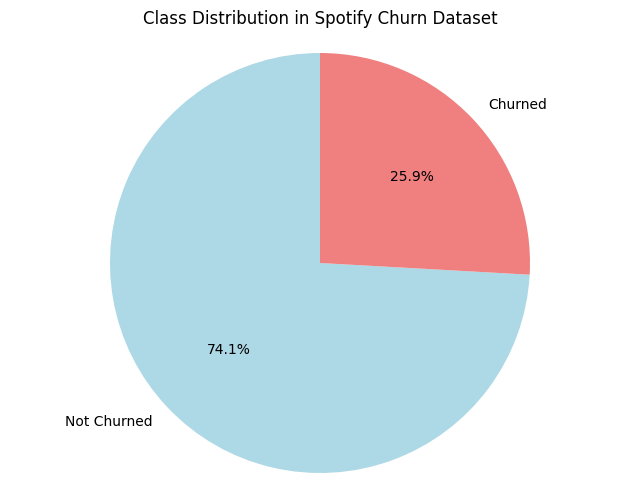

Class distribution:
Not Churned: 5929 (74.1%)
Churned: 2071 (25.9%)
Total samples: 8000
Imbalance ratio: 2.86:1


In [9]:

df = pd.read_csv("spotify_churn_dataset.csv")

# Plot pie chart to show class imbalance
plt.figure(figsize=(8, 6))
churn_counts = df['is_churned'].value_counts()
plt.pie(churn_counts.values, labels=['Not Churned', 'Churned'], autopct='%1.1f%%', 
        colors=['lightblue', 'lightcoral'], startangle=90)
plt.title('Class Distribution in Spotify Churn Dataset')
plt.axis('equal')
plt.show()

print(f"Class distribution:")
print(f"Not Churned: {churn_counts[0]} ({churn_counts[0]/len(df)*100:.1f}%)")
print(f"Churned: {churn_counts[1]} ({churn_counts[1]/len(df)*100:.1f}%)")
print(f"Total samples: {len(df)}")
print(f"Imbalance ratio: {churn_counts[0]/churn_counts[1]:.2f}:1")



2. Show correlation of numeric features 

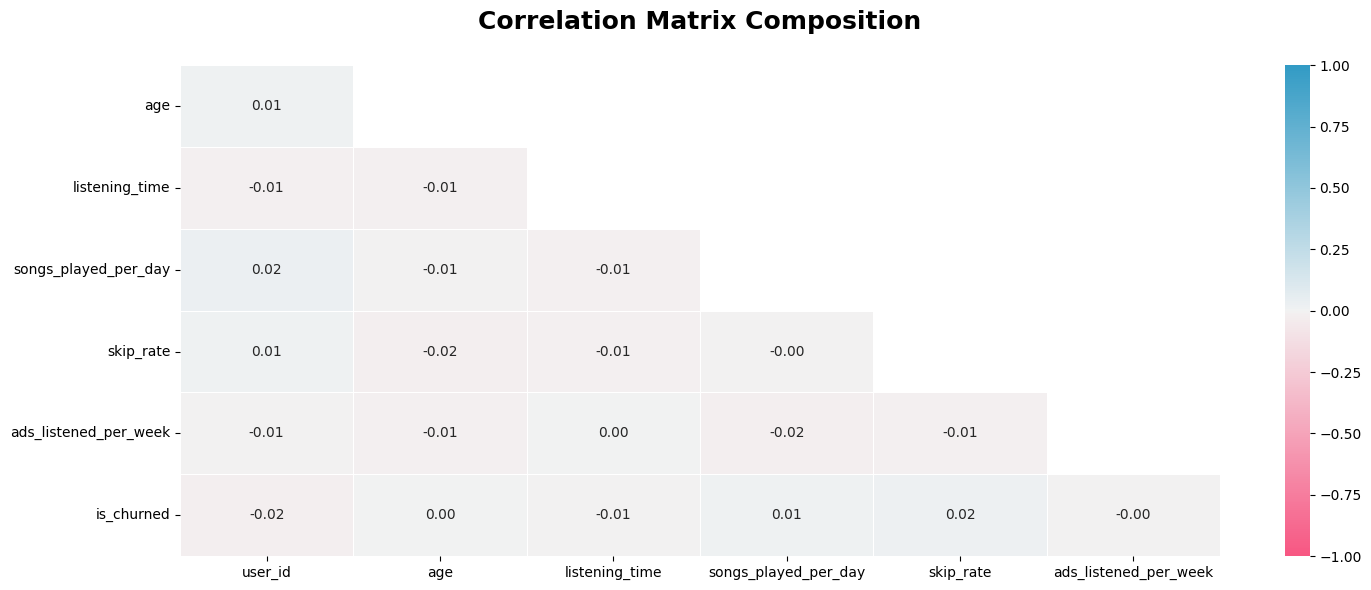

No multicollinearity is observed → all variables can be retained for modeling without redundancy issues.


In [10]:
corr_matrix = df.drop(columns=['offline_listening']).corr(numeric_only=True)
# one_like can build a matrix of boolean(True, False) with the same shape as our data
ones_corr = np.ones_like(corr_matrix, dtype=bool)
mask = np.triu(ones_corr)
adjusted_mask = mask[1:, :-1]
adjusted_cereal_corr = corr_matrix.iloc[1:, :-1]

fig, ax = plt.subplots(figsize = (15, 6))
# That method uses HUSL colors, so you need hue, saturation, and lightness. 
# I used hsluv.org to select the colors of this chart.
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

sns.heatmap(data=adjusted_cereal_corr, mask=adjusted_mask,
            annot=True, fmt=".2f", cmap=cmap,
            vmin=-1, vmax=1, linecolor="white", linewidths=0.5)

title = "Correlation Matrix Composition\n"
ax.set_title(title, loc="center", fontsize=18, weight="bold")
plt.tight_layout()
plt.show()

print("No multicollinearity is observed → all variables can be retained for modeling without redundancy issues.")

3. Create Test Set

    🔴 Suppose you chatted with experts who told you that the listening_time is a very important attribute to predict Churn.

    🔴 We may want to ensure that the test set is representative of the various categories of total charge in the whole dataset. Since the total charge is a continuous numerical attribute, we first need to create an category attribute.

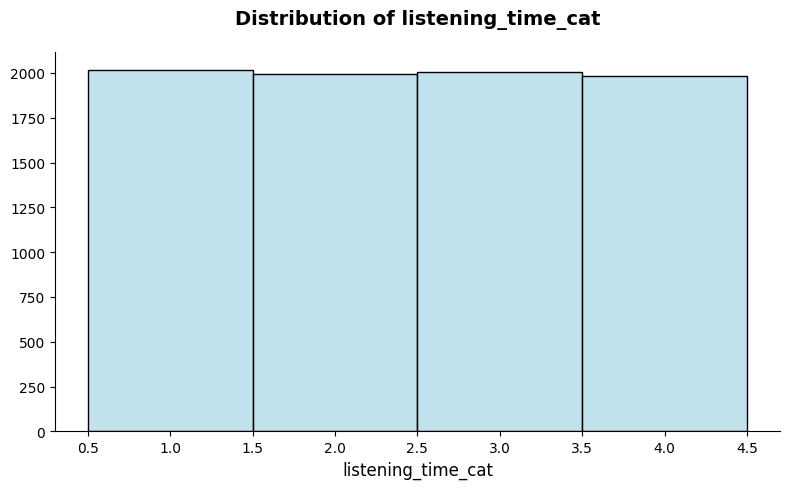

In [11]:
df["listening_time_cat"] = pd.qcut(df["listening_time"],
                                              q=4,
                                              labels=[1, 2, 3, 4])

plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="listening_time_cat", color="lightblue", edgecolor="black")
sns.despine(top=True, right=True, left=False, bottom=False)
plt.title("Distribution of listening_time_cat", fontsize=14, weight="bold",pad=20)
plt.xlabel("listening_time_cat", fontsize=12)
plt.ylabel("")
plt.tight_layout()
plt.show()

In [12]:
split = StratifiedShuffleSplit(n_splits=Config.N_SPLIT, test_size=Config.TEST_SIZE, random_state=Config.SEED)
for train_index, val_index in split.split(df, df["listening_time_cat"]):
    start_train_set = df.loc[train_index]
    start_val_set = df.loc[val_index]

# Now we should remove the listening_time_cat attribute so the data is back to its original state:
for set_ in (start_train_set, start_val_set): 
    set_.drop("listening_time_cat", axis=1, inplace=True)

4. Scale and Encode

In [13]:
df_new = start_train_set.drop("is_churned", axis=1)
df_label = start_train_set["is_churned"].copy()

num_features = ["age", "listening_time", "songs_played_per_day", "ads_listened_per_week"]
cat_features = ["offline_listening", "gender", "country", "subscription_type", "device_type"]

num_transfomer = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("imputer", SimpleImputer(strategy="median"))
])

cat_transfomer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transfomer, num_features),
        ("cat", cat_transfomer, cat_features),
    ]
)

preprocessor.fit(df_new)

df_train_new_prepared = preprocessor.transform(df_new)
list_feature_prepared = preprocessor.get_feature_names_out().tolist()
clean_features = [col.replace("num__", "").replace("cat__", "").replace("PT_", "") for col in list_feature_prepared]

5. Handle imbalance

In [ ]:

from sklearn.utils import resample

# Separate classes
class_0 = df_train_new_prepared[df_label == 0]
class_1 = df_train_new_prepared[df_label == 1]

# Upsample minority class
class_1_upsampled = resample(class_1, 
                            replace=True, 
                            n_samples=len(class_0), 
                            random_state=Config.SEED)

# Combine classes
X_resampled = np.vstack([class_0, class_1_upsampled])
y_resampled = np.hstack([np.zeros(len(class_0)), np.ones(len(class_1_upsampled))])

print("Using sklearn resampling as alternative to SMOTE")

print(f"Original dataset shape: {df_train_new_prepared.shape}")
print(f"Resampled dataset shape: {X_resampled.shape}")
print(f"Original class distribution: {np.bincount(df_label)}")
print(f"Resampled class distribution: {np.bincount(y_resampled.astype(int))}")

Using sklearn resampling as alternative to SMOTE
Original dataset shape: (6400, 24)
Resampled dataset shape: (9580, 24)
Original class distribution: [4790 1610]
Resampled class distribution: [4790 4790]


Evaluation Using Cross-Validation

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=Config.SEED)
models = [
    GaussianNB(),
    KNeighborsClassifier(),
    LogisticRegression(random_state=Config.SEED),
    DecisionTreeClassifier(random_state=Config.SEED),
    RandomForestClassifier(random_state=Config.SEED),
    MLPClassifier(random_state=Config.SEED, max_iter=Config.MAX_ITER),
]

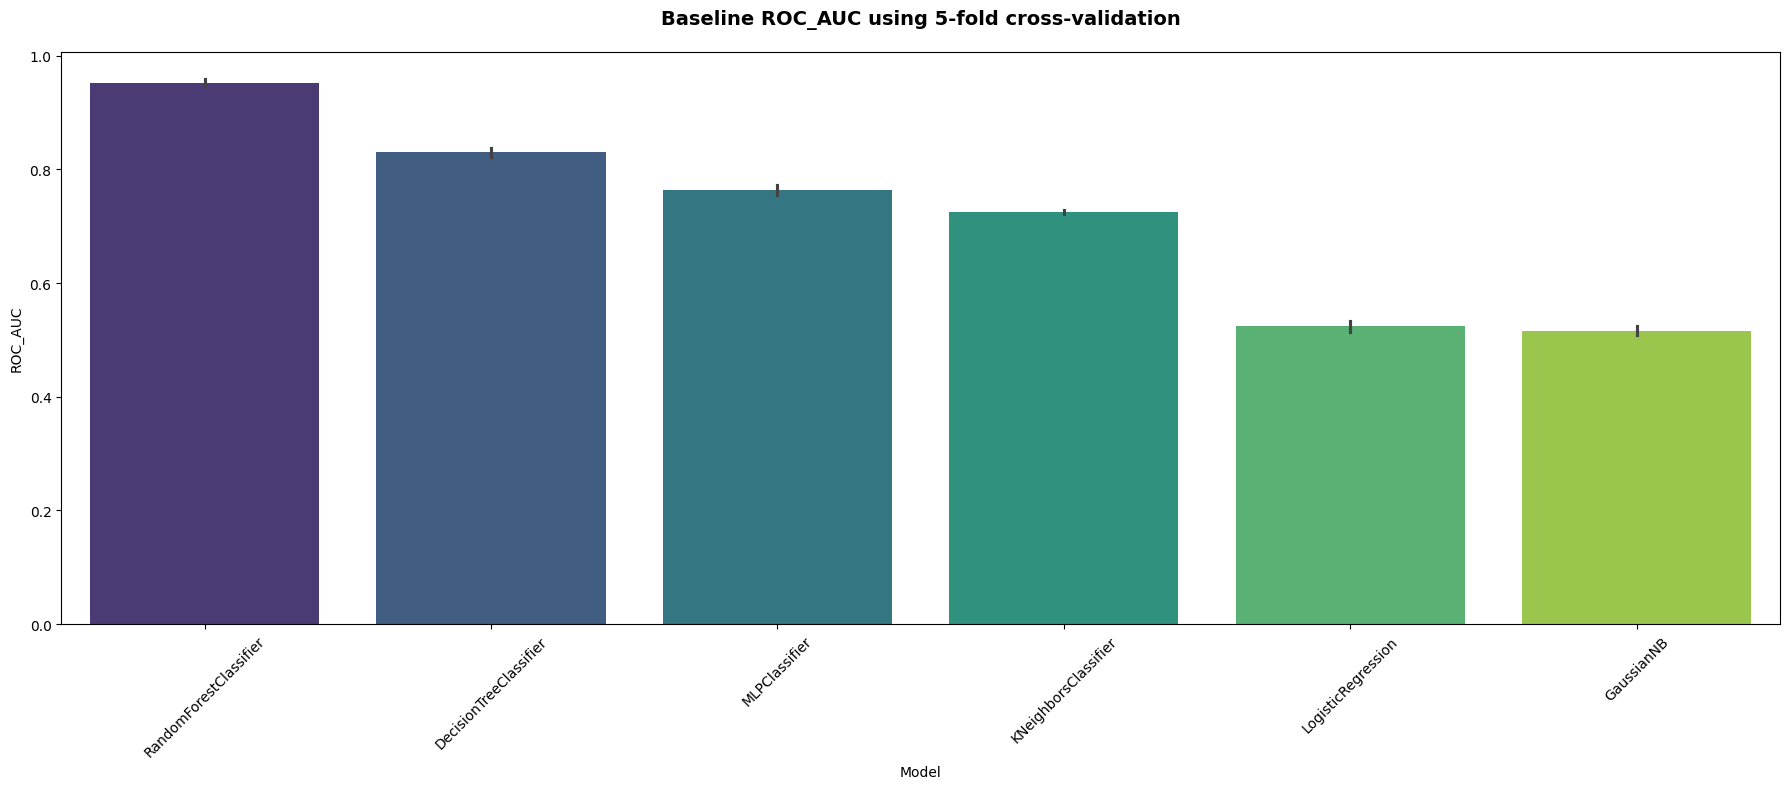

,Mean,Std,N
model_name,,,
RandomForestClassifier,0.952391,0.006539,5
DecisionTreeClassifier,0.829749,0.007718,5
MLPClassifier,0.763644,0.008392,5
KNeighborsClassifier,0.724829,0.003591,5
LogisticRegression,0.523605,0.009138,5
GaussianNB,0.516129,0.008388,5


In [52]:
def generate_baseline_results(models=models, X=X_resampled, y=y_resampled,
                              metric="roc_auc", cv=kfold, plot_result=False):
    entries = []
    for model in models:
        model_name = getattr(model, "name", model.__class__.__name__)
        scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
        for fold_idx, s in enumerate(scores, start=1):
            entries.append((model_name, fold_idx, s))

    cv_df = pd.DataFrame(entries, columns=["model_name", "fold_id", "score"])

    summary = (cv_df.groupby("model_name")["score"]
                    .agg(Mean="mean", Std="std", N="size")
                    .sort_values("Mean", ascending=False))

    if plot_result:
        order = summary.index.tolist()
        plt.figure(figsize=(18, 8))
        sns.barplot(data=cv_df, x="model_name", y="score", order=order, errorbar=("sd"), palette="viridis")
        title_metric = metric.upper() if isinstance(metric, str) else "Score"
        nfolds = getattr(cv, "n_splits", "CV")
        plt.title(f"Baseline {title_metric} using {nfolds}-fold cross-validation", fontsize=14, weight="bold", pad=20)
        plt.xlabel("Model"); plt.ylabel(title_metric)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return summary

display(generate_baseline_results(plot_result = True))

Hyperparameter tunning

In [30]:
# Install and import SHAP
import subprocess
import sys

try:
    import shap
    print("SHAP imported successfully")
except ImportError:
    print("Installing SHAP...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap
    print("SHAP installed and imported successfully")

def shap_plot(model, X_test, list_feature, type=None):
    """
    SHAP plot function for model interpretation
    https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137/
    """
    if hasattr(X_test, "toarray"):
        X_test = X_test.toarray()
    
    X_test_sample = pd.DataFrame(X_test, columns=list_feature)
    
    # Create SHAP explainer
    explainer = shap.Explainer(model.predict, X_test_sample)
    shap_values = explainer(X_test_sample)
    
    if type == "bar":
        # Bar plot for feature importance
        shap_importance = np.abs(shap_values.values).mean(axis=0)
        shap_df = pd.DataFrame({"feature": X_test_sample.columns, "importance": shap_importance})
        shap_df = shap_df.sort_values("importance", ascending=False).head(20)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x=shap_df["importance"], y=shap_df["feature"], palette="viridis", order=shap_df["feature"])
        plt.xlabel("mean(|SHAP value|)")
        plt.title("SHAP Feature Importance", fontsize=14, weight="bold", pad=20)
        plt.tight_layout()
        plt.show()
    else:
        # Summary plot
        shap.summary_plot(shap_values, X_test_sample)

Installing SHAP...
SHAP installed and imported successfully


In [31]:
def plot_ROC_confusionMatrix(estimator, X_val, y_val, figsize):
    y_pred_prob = estimator.predict_proba(X_val)[:, 1]  # Probability of positive class
    y_pred = estimator.predict(X_val)

    fig, ax = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=figsize)

    # Plot 1
    # Calculate ROC
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    rocScore = roc_auc_score(y_val, y_pred_prob)

    ax[0, 0].plot(fpr, tpr, label=f"{estimator.__class__.__name__} (AUC = {rocScore:.2f})")
    ax[0, 0].plot([0, 1], [0, 1], "b--")
    ax[0, 0].set_xlabel("False Positive Rate")
    ax[0, 0].set_ylabel("True Positive Rate")
    ax[0, 0].set_title(f"ROC ({estimator.__class__.__name__})", fontsize=14, weight="bold", pad=20)
    ax[0, 0].legend()

    # Plot 2
    confusionMatrix = confusion_matrix(y_val, y_pred)
    sns.heatmap(confusionMatrix, annot=True, fmt="d", cmap="Blues", ax=ax[0, 1])
    ax[0, 1].set_title(f"Confusion Matrix ({estimator.__class__.__name__})", fontsize=14, weight="bold", pad=20)
    ax[0, 1].set_xlabel("Prediction")
    ax[0, 1].set_ylabel("Actual")

    # plot 3
    avg_prec = average_precision_score(y_val, y_pred_prob)   
    precision, recall, thresholds_pr = precision_recall_curve(y_val, y_pred_prob)
    ax[1, 0].plot(recall, precision, label=f"PR Curve (AP = {avg_prec:.3f})")
    ax[1, 0].set_xlabel("Recall")
    ax[1, 0].set_ylabel("Precision")
    ax[1, 0].set_title("Precision-Recall Curve", fontsize=14, weight="bold", pad=20)
    ax[1, 0].legend()

    ax.flat[-1].set_visible(False)

    plt.tight_layout()
    plt.show()

    print(classification_report(y_val, y_pred))

In [32]:
# Function to evaluate models
def evaluate_model(model, X_train, X_val, y_train, y_val, figsize = (15, 6), show_shap_plot = False):
    print(f"Evaluating {model.__class__.__name__}...")
    model.fit(X_train, y_train)
    plot_ROC_confusionMatrix(estimator = model, X_val = X_val, y_val = y_val, figsize = figsize)
    if show_shap_plot:
        shap_sample = X_val.iloc[:200] if isinstance(X_val, pd.DataFrame) else X_val[:200]
        shap_plot(model=model, X_test=shap_sample, list_feature=list_feature_prepared)

In [33]:
X_val = start_val_set.drop("is_churned", axis=1)
y_val = start_val_set["is_churned"].copy()
X_val_prepared = preprocessor.transform(X_val)

In [54]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_knn = {'weights': 'distance', 'n_neighbors': 3, 'metric': 'minkowski', 'algorithm': 'auto'}
model_knn = KNeighborsClassifier(**param_knn)

param_lr = {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 2000, 'C': 0.001}
model_lr = LogisticRegression(**param_lr)

param_gnb = {'var_smoothing': 1e-6}
model_gnb = GaussianNB(**param_gnb)

param_dt = {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 50, 'criterion': 'entropy'}
model_dt = DecisionTreeClassifier(**param_dt)

param_rf = {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
model_rf = RandomForestClassifier(**param_rf)

param_mlp = {'solver': 'lbfgs', 'max_iter': 500, 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 100), 'alpha': 0.01, 'activation': 'tanh'}
model_mlp = MLPClassifier(**param_mlp)








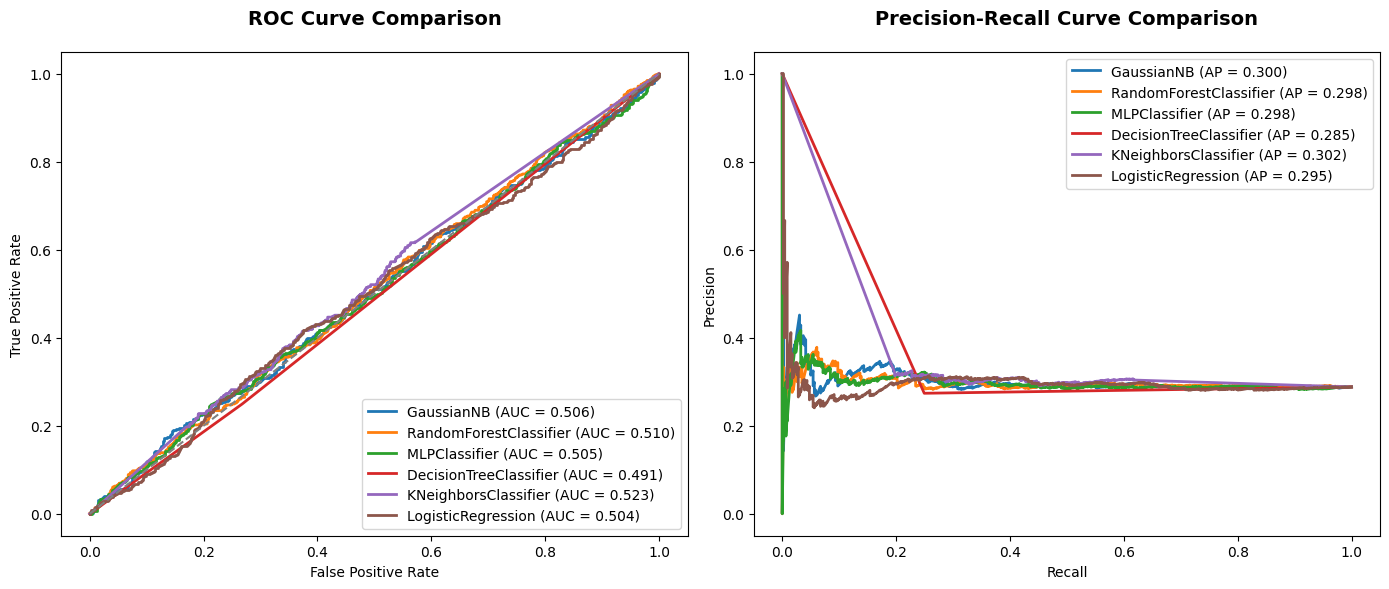

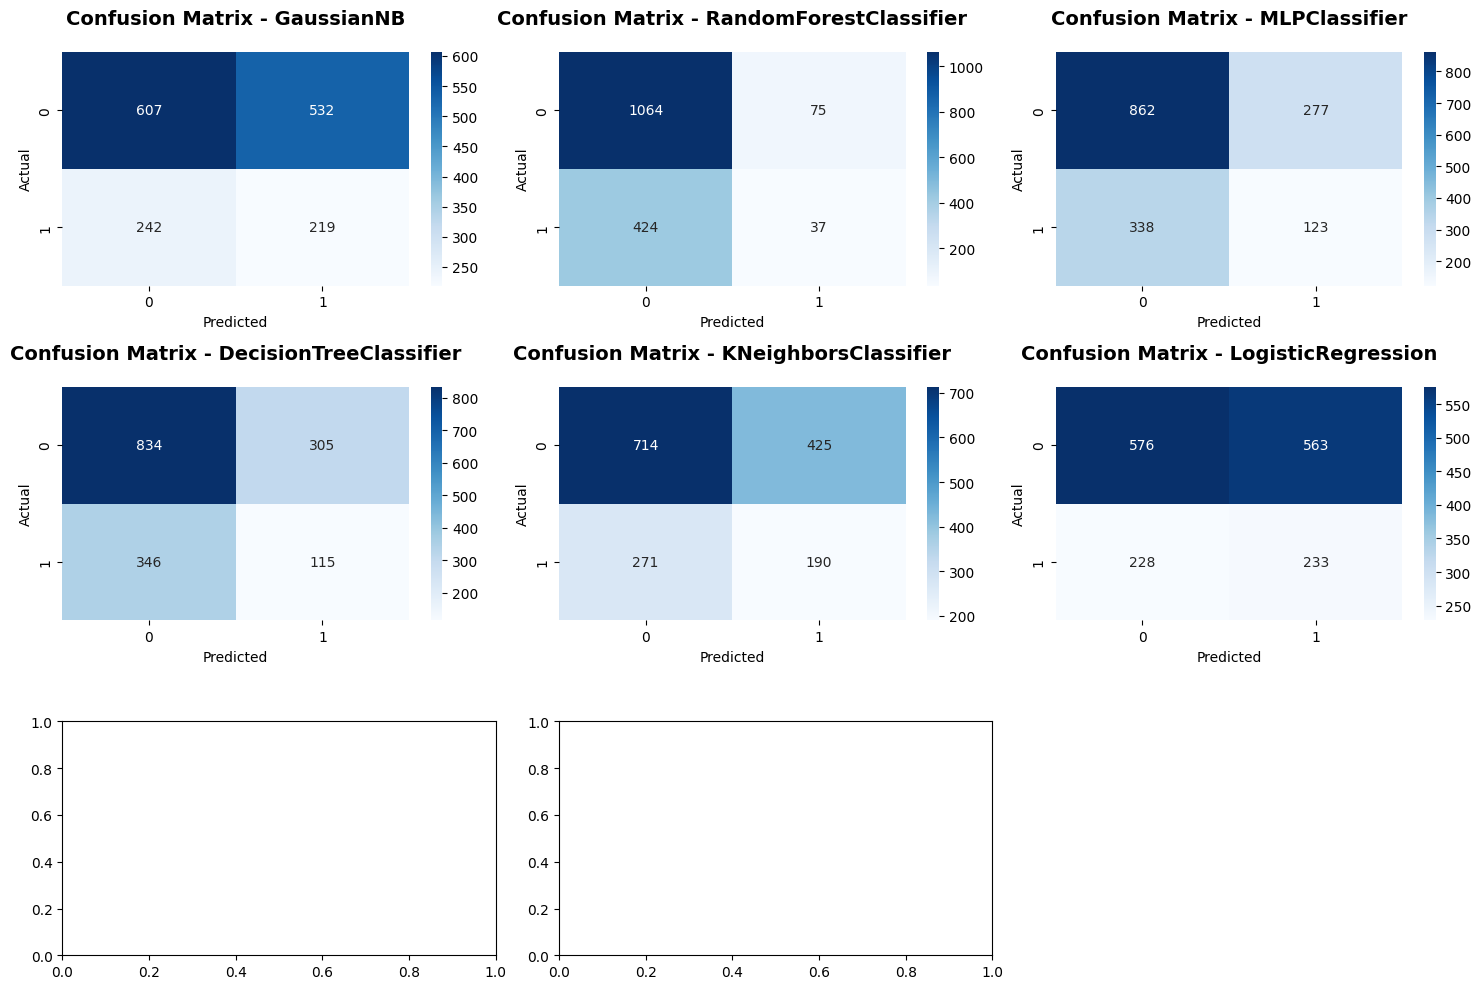

Classification Report - GaussianNB
              precision    recall  f1-score   support

           0      0.715     0.533     0.611      1139
           1      0.292     0.475     0.361       461

    accuracy                          0.516      1600
   macro avg      0.503     0.504     0.486      1600
weighted avg      0.593     0.516     0.539      1600

Classification Report - RandomForestClassifier
              precision    recall  f1-score   support

           0      0.715     0.934     0.810      1139
           1      0.330     0.080     0.129       461

    accuracy                          0.688      1600
   macro avg      0.523     0.507     0.470      1600
weighted avg      0.604     0.688     0.614      1600

Classification Report - MLPClassifier
              precision    recall  f1-score   support

           0      0.718     0.757     0.737      1139
           1      0.307     0.267     0.286       461

    accuracy                          0.616      1600
   macro

In [56]:
models = {
    "GaussianNB": model_gnb,
    "RandomForestClassifier": model_rf,
    "MLPClassifier": model_mlp,
    "DecisionTreeClassifier": model_dt,
    "KNeighborsClassifier": model_knn,
    "LogisticRegression": model_lr,
}

fpr_dict, tpr_dict, roc_auc_dict = {}, {}, {}
prec_dict, rec_dict, pr_auc_dict = {}, {}, {}
y_pred_dict = {}
y_pred_proba_dict = {}

for name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_val_prepared)
    y_pred_proba = model.predict_proba(X_val_prepared)[:, 1]
    
    y_pred_dict[name] = y_pred
    y_pred_proba_dict[name] = y_pred_proba

    # --- ROC ---
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    fpr_dict[name], tpr_dict[name], roc_auc_dict[name] = fpr, tpr, roc_auc

    # --- Precision-Recall Curve ---
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    prec_dict[name], rec_dict[name] = precision, recall

# --- ROC & Precision-Recall Curve on the same figure ---
fig, ax = plt.subplots(1, 2, figsize=(14,6))

# ROC Curve
for name in models.keys():
    ax[0].plot(fpr_dict[name], tpr_dict[name], lw=2,
                 label=f"{name} (AUC = {roc_auc_dict[name]:.3f})")
ax[0].plot([0,1], [0,1], color="gray", linestyle="--")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("ROC Curve Comparison", fontsize=14, weight="bold", pad=20)
ax[0].legend(loc="lower right")

# Precision-Recall Curve
for name in models.keys():
    avg_prec = average_precision_score(y_val, y_pred_proba_dict[name])
    ax[1].plot(rec_dict[name], prec_dict[name], lw=2,
                 label=f"{name} (AP = {avg_prec:.3f})")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("Precision-Recall Curve Comparison", fontsize=14, weight="bold", pad=20)
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

# --- Confusion Matrices ---
fig, ax = plt.subplots(3, 3, figsize=(15,10))
ax = ax.ravel()
for i, (name, model) in enumerate(models.items()):
    cm = confusion_matrix(y_val, y_pred_dict[name])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[i])
    ax[i].set_title(f"Confusion Matrix - {name}", fontsize=14, weight="bold", pad=20)
    ax[i].set_xlabel("Predicted")
    ax[i].set_ylabel("Actual")
ax.flat[-1].set_visible(False)
plt.tight_layout()
plt.show()

# --- Classification Reports ---
for name in models.keys():
    print("="*50)
    print(f"Classification Report - {name}")
    print(classification_report(y_val, y_pred_dict[name], digits=3))

In [ ]:
# Hyperparameter Tuning for Multiple Models
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import time

# Define hyperparameter grids for each model
hyperparameter_grids = {
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': ['sqrt', 'log2', None]
    },
    
    'MLPClassifier': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
        'activation': ['relu', 'tanh', 'logistic'],
        'solver': ['adam', 'lbfgs', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [200, 500, 1000]
    },
    
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    
    'GaussianNB': {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    },
    
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['liblinear', 'lbfgs', 'saga'],
        'max_iter': [100, 500, 1000, 2000]
    },
    
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 200, 300, 500],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }
}

# Model instances
models_for_tuning = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
    'LogisticRegression': LogisticRegression(random_state=Config.SEED),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=Config.SEED),
    'RandomForestClassifier': RandomForestClassifier(random_state=Config.SEED),
    'MLPClassifier': MLPClassifier(random_state=Config.SEED)
}

print("Hyperparameter grids defined for 6 models:")
for model_name, params in hyperparameter_grids.items():
    print(f"{model_name}: {len(params)} parameter combinations")
print(f"\nTotal models to tune: {len(models_for_tuning)}")
print("Ready to perform hyperparameter tuning...")


NameError: name 'Config' is not defined

In [ ]:
# Execute Hyperparameter Tuning
print("Starting hyperparameter tuning for all models...")
print("="*60)

# Store results
tuning_results = {}
best_models = {}

# Use RandomizedSearchCV for faster tuning (can switch to GridSearchCV for exhaustive search)
for model_name, model in models_for_tuning.items():
    print(f"\nTuning {model_name}...")
    start_time = time.time()
    
    # Use RandomizedSearchCV for efficiency (n_iter=50 for good coverage)
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=hyperparameter_grids[model_name],
        n_iter=50,  # Number of parameter settings sampled
        cv=5,       # 5-fold cross-validation
        scoring='f1',  # Use F1 score for imbalanced data
        n_jobs=-1,  # Use all available cores
        random_state=Config.SEED,
        verbose=1
    )
    
    # Fit the search
    search.fit(X_resampled, y_resampled)
    
    end_time = time.time()
    tuning_time = end_time - start_time
    
    # Store results
    tuning_results[model_name] = {
        'best_params': search.best_params_,
        'best_score': search.best_score_,
        'tuning_time': tuning_time,
        'cv_results': search.cv_results_
    }
    
    best_models[model_name] = search.best_estimator_
    
    print(f"Best F1 Score: {search.best_score_:.4f}")
    print(f"Best Parameters: {search.best_params_}")
    print(f"Tuning Time: {tuning_time:.2f} seconds")
    print("-" * 40)

print("\n" + "="*60)
print("HYPERPARAMETER TUNING COMPLETED!")
print("="*60)


Starting hyperparameter tuning for all models...

Tuning KNeighborsClassifier...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best F1 Score: 0.8155
Best Parameters: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'minkowski', 'algorithm': 'auto'}
Tuning Time: 5.72 seconds
----------------------------------------

Tuning RidgeClassifier...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best F1 Score: 0.5197
Best Parameters: {'solver': 'sag', 'max_iter': 1000, 'fit_intercept': True, 'class_weight': 'balanced', 'alpha': 100.0}
Tuning Time: 1.63 seconds
----------------------------------------

Tuning LogisticRegression...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best F1 Score: 0.5295
Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 2000, 'C': 0.001}
Tuning Time: 1.35 seconds
----------------------------------------

Tuning DecisionTreeClassifier...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Be

HYPERPARAMETER TUNING RESULTS SUMMARY

Results Summary (sorted by F1 Score):
                 Model  Best_F1_Score  Tuning_Time_sec                                                                                                                          Best_Parameters
RandomForestClassifier       0.912953        57.641179        {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
         MLPClassifier       0.852120       307.419096 {'solver': 'lbfgs', 'max_iter': 500, 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 100), 'alpha': 0.01, 'activation': 'tanh'}
DecisionTreeClassifier       0.843346         0.685370                           {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 50, 'criterion': 'entropy'}
  KNeighborsClassifier       0.815487         5.720657                                                    {'weights': 'distance', 'n_neighbors': 3, 'metric

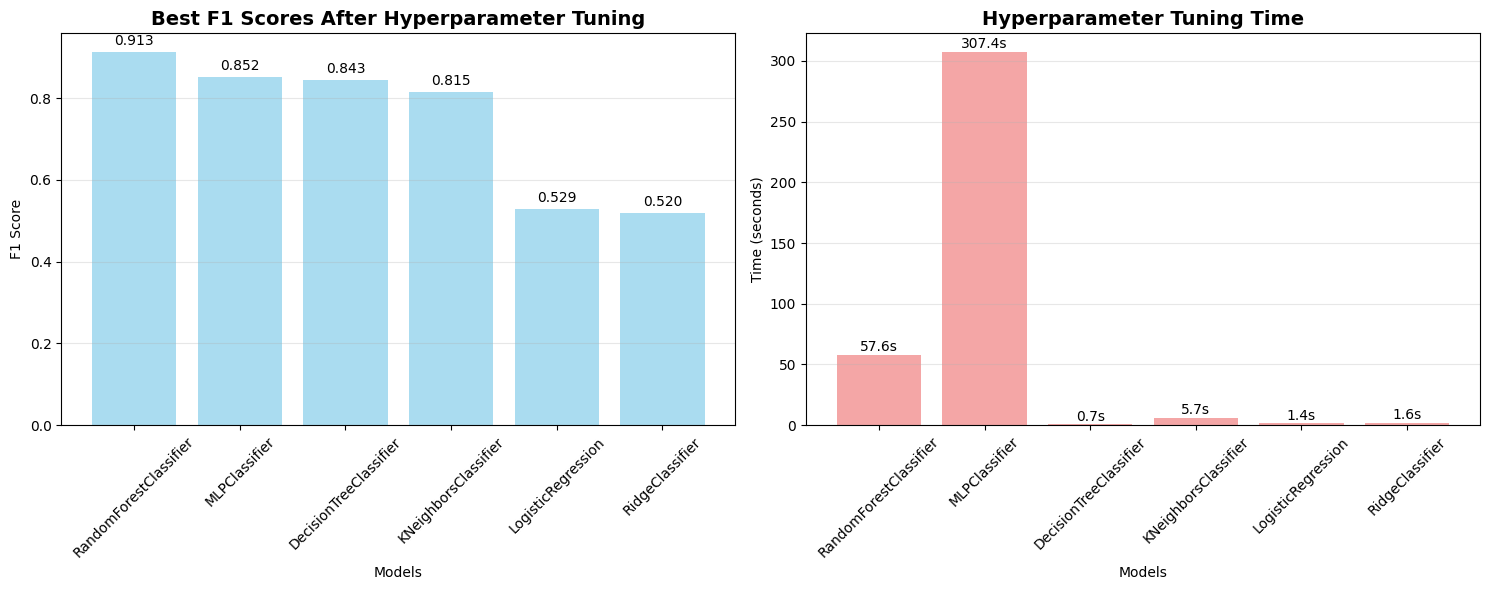


DETAILED BEST PARAMETERS FOR EACH MODEL

KNeighborsClassifier:
Best F1 Score: 0.8155
Tuning Time: 5.72 seconds
Best Parameters:
  weights: distance
  n_neighbors: 3
  metric: minkowski
  algorithm: auto
----------------------------------------

RidgeClassifier:
Best F1 Score: 0.5197
Tuning Time: 1.63 seconds
Best Parameters:
  solver: sag
  max_iter: 1000
  fit_intercept: True
  class_weight: balanced
  alpha: 100.0
----------------------------------------

LogisticRegression:
Best F1 Score: 0.5295
Tuning Time: 1.35 seconds
Best Parameters:
  solver: liblinear
  penalty: l2
  max_iter: 2000
  C: 0.001
----------------------------------------

DecisionTreeClassifier:
Best F1 Score: 0.8433
Tuning Time: 0.69 seconds
Best Parameters:
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: None
  max_depth: 50
  criterion: entropy
----------------------------------------

RandomForestClassifier:
Best F1 Score: 0.9130
Tuning Time: 57.64 seconds
Best Parameters:
  n_estimators: 200
  mi

In [44]:
# Analyze and Display Tuning Results
print("HYPERPARAMETER TUNING RESULTS SUMMARY")
print("="*60)

# Create results DataFrame
results_data = []
for model_name, results in tuning_results.items():
    results_data.append({
        'Model': model_name,
        'Best_F1_Score': results['best_score'],
        'Tuning_Time_sec': results['tuning_time'],
        'Best_Parameters': str(results['best_params'])
    })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('Best_F1_Score', ascending=False)

print("\nResults Summary (sorted by F1 Score):")
print(results_df.to_string(index=False))

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# F1 Score comparison
ax1.bar(results_df['Model'], results_df['Best_F1_Score'], color='skyblue', alpha=0.7)
ax1.set_title('Best F1 Scores After Hyperparameter Tuning', fontsize=14, weight='bold')
ax1.set_ylabel('F1 Score')
ax1.set_xlabel('Models')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(results_df['Best_F1_Score']):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Tuning time comparison
ax2.bar(results_df['Model'], results_df['Tuning_Time_sec'], color='lightcoral', alpha=0.7)
ax2.set_title('Hyperparameter Tuning Time', fontsize=14, weight='bold')
ax2.set_ylabel('Time (seconds)')
ax2.set_xlabel('Models')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(results_df['Tuning_Time_sec']):
    ax2.text(i, v + 0.5, f'{v:.1f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Display best parameters for each model
print("\n" + "="*60)
print("DETAILED BEST PARAMETERS FOR EACH MODEL")
print("="*60)

for model_name, results in tuning_results.items():
    print(f"\n{model_name}:")
    print(f"Best F1 Score: {results['best_score']:.4f}")
    print(f"Tuning Time: {results['tuning_time']:.2f} seconds")
    print("Best Parameters:")
    for param, value in results['best_params'].items():
        print(f"  {param}: {value}")
    print("-" * 40)

print(f"\nBest performing model: {results_df.iloc[0]['Model']} (F1 Score: {results_df.iloc[0]['Best_F1_Score']:.4f})")
